# plaq-u-net: multi-patch consensus U-Net for automated detection and segmentation of the carotid arteries on black blood MRI sequences

E. Lavrova, 2022

This is a code supporting the corresponding paper.

Packages import:

In [41]:
import numpy as np
import os
import glob
from skimage.measure import label
import pydicom
import matplotlib.pyplot as plt
import pandas as pd
from skimage import morphology
from scipy.stats import iqr
from scipy.stats import binom_test

from sklearn.metrics import mean_squared_error

import seaborn as sns

In [2]:
def calculate_dice(mask_1, mask_2):
    intersection = np.sum(mask_1*mask_2)
    sum_area = np.sum(mask_1) + np.sum(mask_2)
    return 2*intersection/sum_area

def calculate_overlap(mask_1, mask_2):
    o = 0
    if (np.sum(mask_1)>0)&(np.sum(mask_2)>0):
        intersection = np.sum(mask_1*mask_2)
        min_area = min(np.sum(mask_1), np.sum(mask_2))
        o =intersection/min_area
    if (np.sum(mask_1)==0)&(np.sum(mask_2)==0):
        o = 1
    return o

In [3]:
def path2array(dcm_path, cut=True):
    arr_dcm = pydicom.read_file(dcm_path, force = True)
    arr_dcm.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
    arr = arr_dcm.pixel_array
    if cut:
        arr = arr[8:-8,8:-8]
    pix_spc_ch = arr_dcm.PixelSpacing
    pix_spc = [float(pix_spc_ch[0]), float(pix_spc_ch[1])]
    sl_thick = arr_dcm.SliceThickness
    return arr, pix_spc, sl_thick

In [4]:
def detect_label(label_mask, gt_mask):
    
    max_overlap = 0
    max_label = 100
    max_dice = 0
    
    for l in range(1, np.max(label_mask)+1):
        
        label_mask_l = label_mask==l
        d = calculate_dice(label_mask_l, gt_mask)
        o = calculate_overlap(label_mask_l, gt_mask)
        
        if o>max_overlap:
            
            max_overlap = o
            max_label = l
            max_dice = d        
            
    return max_label, max_overlap, max_dice

In [5]:
import scipy.stats
import math
import random


def clopper_pearson(x, n, alpha=0.05):

    b = scipy.stats.beta.ppf
    lo = b(alpha / 2, x, n - x + 1)
    hi = b(1 - alpha / 2, x + 1, n - x)
    return 0.0 if math.isnan(lo) else lo, 1.0 if math.isnan(hi) else hi

In [10]:
def get_mask_from_map(vessel_map):
    
    vessel_map_processed = morphology.remove_small_objects(vessel_map>0.5, 50, connectivity=3)
    vessel_map_labeled = label(vessel_map_processed)

    label_weights = []

    for l in range(1, np.max(vessel_map_labeled)+1):
    
        vessel_map_label = (vessel_map_labeled==l).astype(np.uint8)
        weight_label = np.sum(vessel_map_label*vessel_map)
        rec_lw = {'label': l, 'weight': weight_label}
        label_weights.append(rec_lw)

    label_weights = pd.DataFrame(label_weights)
    n_labels = min(len(label_weights), 6)
    labels = []
            
    if len(label_weights)>0:

        label_weights.sort_values(by='weight', inplace=True, ascending = False)
        labels = np.array(label_weights['label'])[:n_labels]

    vessel_mask = np.isin(vessel_map_labeled, labels)
    
    return vessel_mask

In [17]:
from numpy import ones, kron, mean, eye, hstack, dot, tile
from numpy.linalg import pinv

def icc(Y, icc_type='ICC(2,1)'):
    ''' Calculate intraclass correlation coefficient

    ICC Formulas are based on:
    Shrout, P. E., & Fleiss, J. L. (1979). Intraclass correlations: uses in
    assessing rater reliability. Psychological bulletin, 86(2), 420.
    icc1:  x_ij = mu + beta_j + w_ij
    icc2/3:  x_ij = mu + alpha_i + beta_j + (ab)_ij + epsilon_ij
    Code modifed from nipype algorithms.icc
    https://github.com/nipy/nipype/blob/master/nipype/algorithms/icc.py

    Args:
        Y: The data Y are entered as a 'table' ie. subjects are in rows and repeated
            measures in columns
        icc_type: type of ICC to calculate. (ICC(2,1), ICC(2,k), ICC(3,1), ICC(3,k)) 
    Returns:
        ICC: (np.array) intraclass correlation coefficient
    '''

    [n, k] = Y.shape

    # Degrees of Freedom
    dfc = k - 1
    dfe = (n - 1) * (k-1)
    dfr = n - 1

    # Sum Square Total
    mean_Y = np.mean(Y)
    SST = ((Y - mean_Y) ** 2).sum()

    # create the design matrix for the different levels
    x = np.kron(np.eye(k), np.ones((n, 1)))  # sessions
    x0 = np.tile(np.eye(n), (k, 1))  # subjects
    X = np.hstack([x, x0])

    # Sum Square Error
    predicted_Y = np.dot(np.dot(np.dot(X, np.linalg.pinv(np.dot(X.T, X))),
                                X.T), Y.flatten('F'))
    residuals = Y.flatten('F') - predicted_Y
    SSE = (residuals ** 2).sum()

    MSE = SSE / dfe

    # Sum square column effect - between colums
    SSC = ((np.mean(Y, 0) - mean_Y) ** 2).sum() * n
    MSC = SSC / dfc  # / n (without n in SPSS results)

    # Sum Square subject effect - between rows/subjects
    SSR = SST - SSC - SSE
    MSR = SSR / dfr

    if icc_type == 'icc1':
        # ICC(2,1) = (mean square subject - mean square error) /
        # (mean square subject + (k-1)*mean square error +
        # k*(mean square columns - mean square error)/n)
        # ICC = (MSR - MSRW) / (MSR + (k-1) * MSRW)
        NotImplementedError("This method isn't implemented yet.")

    elif icc_type == 'ICC(2,1)' or icc_type == 'ICC(2,k)':
        # ICC(2,1) = (mean square subject - mean square error) /
        # (mean square subject + (k-1)*mean square error +
        # k*(mean square columns - mean square error)/n)
        if icc_type == 'ICC(2,k)':
            k = 1
        ICC = (MSR - MSE) / (MSR + (k-1) * MSE + k * (MSC - MSE) / n)

    elif icc_type == 'ICC(3,1)' or icc_type == 'ICC(3,k)':
        # ICC(3,1) = (mean square subject - mean square error) /
        # (mean square subject + (k-1)*mean square error)
        if icc_type == 'ICC(3,k)':
            k = 1
        ICC = (MSR - MSE) / (MSR + (k-1) * MSE)

    return ICC

In [69]:
def bland_altman_plot(x_1, x_2, unit):
    
    x_1 = np.asarray(x_1)
    x_2 = np.asarray(x_2)
    mean = np.mean([x_1, x_2], axis=0)
    diff = x_1 - x_2                   
    md = np.mean(diff)                  
    sd = np.std(diff, axis=0) 
    
    plt.figure(figsize=(5, 5))

    plt.scatter(mean, diff)
    plt.axhline(md, color='gray', linestyle='-', label='MD: '+str(round(md, 2)))
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--', label='MD + 1.96SD: '+str(round(md + 1.96*sd, 2)))
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--', label='MD - 1.96SD: '+str(round(md - 1.96*sd, 2)))
    plt.legend()
    plt.xlabel('Average between manually and automatically estimated masks, '+unit)
    plt.ylabel('Difference between manually and automatically estimated masks, '+unit)
    plt.show()

In [70]:
def get_outcomes(sub_names, ds_dir, results_dir, cut=True, mapstrategy=True):
    
    df_outcomes = []
    
    detect_slice = []
    dice_slice = []
    overlap_slice = []
    
    area_difference = []
    area_groundtruth = []
    area_predicted = []
    
    volume_groundtruth = []
    volume_predicted = []
    
    for sub_name in sub_names:
        
    
        rec = {'sub': sub_name}

        gt_sub_dir = ds_dir + sub_name + '/MASSExport/'

        filenames = os.listdir(gt_sub_dir)
        filenames.sort()

        mask2d_gt_0, pixel_spacing_0, slice_thickness_0 = path2array(gt_sub_dir + '/' + filenames[0], cut=cut)
        dim = mask2d_gt_0.shape

        mask3d_pred = np.zeros([dim[0], dim[1], len(filenames)], dtype=np.float)
        mask3d_gt = np.zeros([dim[0], dim[1], len(filenames)], dtype=np.uint8)

        counter = 0

        detect_slice_sub = []
        dice_slice_sub = []
        overlap_slice_sub = []
        
        area_difference_sub = []
        area_groundtruth_sub = []
        area_predicted_sub = []

        detected=0

        for filename in filenames:

            sl = filename[-17:-11]
            
            gt_path = gt_sub_dir + '/' + filename
            pred_path = glob.glob(results_dir + '/' + sub_name + '*/*' + sl + '*.npy')[0]
            gt_array, pixel_spacing_gt, slice_thickness_gt = path2array(gt_path, cut=cut)

            mask2d_gt = (gt_array>0)&(gt_array<7)
            mask2d_pred = np.load(pred_path)
            
            mask2d_pred_bin = mask2d_pred.copy()
            
            if mapstrategy:
                mask2d_pred_bin = get_mask_from_map(mask2d_pred)
                
            mask2d_pred_labeled = label(mask2d_pred_bin)
            
            labels = list(np.unique(mask2d_pred_labeled))
            labels.remove(0)

            detected = 0
            max_overlap = 0
            max_label = 100
            max_dice = 0            
        
            for l in labels:

                mask2d_pred_label = (mask2d_pred_labeled==l).astype(np.uint8)
                d = calculate_dice(mask2d_pred_label, mask2d_gt)
                o = calculate_overlap(mask2d_pred_label, mask2d_gt)

                if o>max_overlap:

                    max_overlap = o
                    max_label = l
                    max_dice = d

            if (max_overlap>0.5):
                detected = 1
                
            mask2d_pred_selected = (mask2d_pred_labeled==max_label).astype(np.uint8)
                
            mask3d_gt[:, :, counter] = mask2d_gt
            mask3d_pred[:, :, counter] = mask2d_pred_selected
            
            detect_slice_sub.append(detected)
            dice_slice_sub.append(max_dice)
            overlap_slice_sub.append(max_overlap)
            
            detect_slice.append(detected)
            dice_slice.append(max_dice)
            overlap_slice.append(max_overlap)
            
            area_gt = np.sum(mask2d_gt)
            area_pred = np.sum(mask2d_pred_selected)
            area_diff = abs(area_gt-area_pred)*pixel_spacing_0[0]*pixel_spacing_0[1]
            
            area_difference.append(area_diff)
            area_difference_sub.append(area_diff)
            area_groundtruth.append(area_gt)
            area_groundtruth_sub.append(area_gt)
            area_predicted.append(area_pred)
            area_predicted_sub.append(area_pred)
            
            counter+=1
            
        rec['detect_slice'] = detect_slice_sub
        rec['overlap_slice'] = overlap_slice_sub
        rec['dice_slice'] = dice_slice_sub
        rec['area_difference_slice'] = area_difference_sub
        
        volume_difference_patient_abs=abs(np.sum(mask3d_gt)-np.sum(mask3d_pred))*pixel_spacing_0[0]*pixel_spacing_0[1]*slice_thickness_0
        volume_difference_patient_rel=abs(np.sum(mask3d_gt)-np.sum(mask3d_pred))/np.sum(mask3d_gt)
        
        volume_groundtruth.append(np.sum(mask3d_gt)*pixel_spacing_0[0]*pixel_spacing_0[1]*slice_thickness_0)
        volume_predicted.append(np.sum(mask3d_pred)*pixel_spacing_0[0]*pixel_spacing_0[1]*slice_thickness_0)
        
        rec['detect_patient'] = int(calculate_overlap(mask3d_pred, mask3d_gt)>0.5)
        rec['overlap_patient'] = calculate_overlap(mask3d_pred, mask3d_gt)
        rec['dice_patient'] = calculate_dice(mask3d_pred, mask3d_gt)
        rec['volume_difference_patient_abs'] = volume_difference_patient_abs
        rec['volume_difference_patient_rel'] = volume_difference_patient_rel

        df_outcomes.append(rec)

    df_outcomes = pd.DataFrame(df_outcomes)
    area_difference_relative = abs(np.array(area_groundtruth)-np.array(area_predicted))/np.array(area_groundtruth)
        
    print ('Slice\n')

    print ('Mean TPR, OC, DSC: ', np.mean(detect_slice), np.mean(overlap_slice), np.mean(dice_slice))
    print ('Median TPR, OC, DSC: ', np.median(detect_slice), np.median(overlap_slice), np.median(dice_slice))
    print ('IQR TPR, OC, DSC: ', iqr(detect_slice), iqr(overlap_slice), iqr(dice_slice))
    print ('CP 90% CI TPR: ', clopper_pearson(x=np.sum(detect_slice), n=len(detect_slice), alpha=0.1))
    print ('MSE area, mm2: ', mean_squared_error(area_groundtruth, area_predicted))
    print ('Mean, median, IQR area difference, mm2: ', 
           np.mean(area_difference), np.median(area_difference), iqr(area_difference))
    print ('Mean, median area difference, IQR, relative: ', 
           np.mean(area_difference_relative), np.median(area_difference_relative), iqr(area_difference_relative))
    print ('Mean area GT, pred: ', np.mean(area_groundtruth), np.mean(area_predicted))
    print ('Median area GT, pred: ', np.median(area_groundtruth), np.median(area_predicted))
    print ('Area difference ICC: ', 
           icc(np.column_stack((area_groundtruth, area_predicted)), icc_type='ICC(2,k)'))
    print ('R Spearman for areas: ', scipy.stats.spearmanr(area_groundtruth, area_predicted)[0])
    print ('R2 for areas: ', scipy.stats.linregress(area_groundtruth, area_predicted)[2])

    plt.figure(figsize=(15, 3))

    plt.subplot(1, 4, 1)
    plt.hist(detect_slice)
    plt.title('Detected')

    plt.subplot(1, 4, 2)
    plt.hist(overlap_slice)
    plt.title('OC')

    plt.subplot(1, 4, 3)
    plt.hist(dice_slice)
    plt.title('DSC')
    
    plt.subplot(1, 4, 4)
    plt.hist(area_difference)
    plt.title('Absolute area difference')

    plt.show()
    
    plt.figure(figsize=(5, 5))
    ax = sns.regplot(area_groundtruth, area_predicted, line_kws={'label': 'Regression line'})
    ax.collections[1].set_label('95% confidence interval')
    plt.legend()
    plt.xlabel('Manual segmentation area, $mm^2$')
    plt.ylabel('Autosegmentation area, $mm^2$')
    plt.title('$R^2$ = '+str(round(scipy.stats.linregress(area_groundtruth, area_predicted)[2], 2)))
    plt.show()
    
    bland_altman_plot(area_groundtruth, area_predicted, '$mm^2$')

    print ('Patient\n')

    print ('Mean TPR, OC, DSC: ', 
           np.mean(df_outcomes['detect_patient']), 
           np.mean(df_outcomes['overlap_patient']), 
           np.mean(df_outcomes['dice_patient']))

    print ('Median TPR, OC, DSC: ',
           np.median(df_outcomes['detect_patient']), 
           np.median(df_outcomes['overlap_patient']), 
           np.median(df_outcomes['dice_patient']))

    print ('IQR TPR, OC, DSC: ',
           iqr(df_outcomes['detect_patient']), 
           iqr(df_outcomes['overlap_patient']), 
           iqr(df_outcomes['dice_patient']))

    print ('CP 90% CI TPR: ',
           clopper_pearson(x=np.sum(np.array(df_outcomes['detect_patient'])), 
                           n=len(np.array(df_outcomes['detect_patient'])), alpha=0.1))
    
    print ('MSE volume, mm3: ', mean_squared_error(volume_groundtruth, volume_predicted))
    
    print ('Mean, median, IQR volume difference, mm3: ', 
           np.mean(df_outcomes['volume_difference_patient_abs']), 
           np.median(df_outcomes['volume_difference_patient_abs']), 
           iqr(df_outcomes['volume_difference_patient_abs']))
    
    print ('Mean, median, IQR volume difference, rel: ', 
           np.mean(df_outcomes['volume_difference_patient_rel']), 
           np.median(df_outcomes['volume_difference_patient_rel']), 
           iqr(df_outcomes['volume_difference_patient_rel']))
    
    print ('Volume difference ICC: ', 
           icc(np.column_stack((volume_groundtruth, volume_predicted)), icc_type='ICC(2,k)'))
    
    print ('R Spearman for volumes: ', scipy.stats.spearmanr(volume_groundtruth, volume_predicted)[0])
    
    print ('R2 for volumes: ', scipy.stats.linregress(volume_groundtruth, volume_predicted)[2])
    
    plt.figure(figsize=(5, 5))
    ax = sns.regplot(volume_groundtruth, volume_predicted, line_kws={'label': 'Regression line'})
    ax.collections[1].set_label('95% confidence interval')
    plt.legend()
    plt.xlabel('Manual segmentation volume, $mm^3$')
    plt.ylabel('Autosegmentation volume, $mm^3$')
    plt.title('$R^2$ = '+str(round(scipy.stats.linregress(volume_groundtruth, volume_predicted)[2], 2)))
    plt.show()
    
    bland_altman_plot(volume_groundtruth, volume_predicted, '$mm^3$')

    
    return df_outcomes

In [142]:
def visualize_results(sub_name, sl, cut=True, large=False, modality = 'T1w'):

    gt_path = glob.glob('../data/'+sub_name+'/MASSExport/*'+sl+'*.dcm')[0]
    img_path = glob.glob('../data/'+sub_name+'/'+modality+'_*'+sl+'*.dcm')[0]

    ds_dir = '../data/'
    results_dir_plaqunet_simple = '../res/maps/'+modality+'/plaq-u-net_simple/'
    results_dir_plaqunet_aug = '../res/maps/'+modality+'/plaq-u-net_aug/'
    results_dir_unet_simple = '../res/maps/'+modality+'/u-net_simple/'
    results_dir_unet_aug = '../res/maps/'+modality+'/u-net_aug/'
    results_dir_maskrcnn_simple = '../res/maps/'+modality+'/mask-rcnn_simple/'
    results_dir_maskrcnn_aug = '../res/maps/'+modality+'/mask-rcnn_aug/'

    sl = gt_path[-17:-11]

    pred_path_plaqunet_simple = glob.glob(results_dir_plaqunet_simple + '/' + sub_name + '*/*' + sl + '*.npy')[0]
    pred_path_plaqunet_aug = glob.glob(results_dir_plaqunet_aug + '/' + sub_name + '*/*' + sl + '*.npy')[0]
    pred_path_unet_simple = glob.glob(results_dir_unet_simple + '/' + sub_name + '*/*' + sl + '*.npy')[0]
    pred_path_unet_aug = glob.glob(results_dir_unet_aug+ '/' + sub_name + '*/*' + sl + '*.npy')[0]
    pred_path_maskrcnn_simple = glob.glob(results_dir_maskrcnn_simple + '/' + sub_name + '*/*' + sl + '*.npy')[0]
    pred_path_maskrcnn_aug = glob.glob(results_dir_maskrcnn_aug + '/' + sub_name + '*/*' + sl + '*.npy')[0]

    img, ps, st = path2array(img_path, cut=cut)
    gt_array, pixel_spacing_gt, slice_thickness_gt = path2array(gt_path, cut=cut)
    mask2d_gt = (gt_array>0)&(gt_array<7)

    map_pred_plaqunet_simple = np.load(pred_path_plaqunet_simple)
    mask_pred_plaqunet_simple = get_mask_from_map(map_pred_plaqunet_simple)

    map_pred_plaqunet_aug = np.load(pred_path_plaqunet_aug)
    mask_pred_plaqunet_aug = get_mask_from_map(map_pred_plaqunet_aug)

    map_pred_unet_simple = np.load(pred_path_unet_simple)
    mask_pred_unet_simple = get_mask_from_map(map_pred_unet_simple)

    map_pred_unet_aug = np.load(pred_path_unet_aug)
    mask_pred_unet_aug = get_mask_from_map(map_pred_unet_aug)

    mask_pred_maskrcnn_simple = np.load(pred_path_maskrcnn_simple)
    mask_pred_maskrcnn_aug = np.load(pred_path_maskrcnn_aug)
    
    dim = img.shape
    x_min = 0
    x_max = dim[0]-1
    y_min = 0
    y_max = dim[1]-1
    
    if large:
        x_c = int(np.median(np.where(mask2d_gt>0)[0]))
        y_c = int(np.median(np.where(mask2d_gt>0)[1]))
        x_max = x_c+64
        x_min = x_c-64
        y_max = y_c+64
        y_min = y_c-64
        

    plt.figure(figsize=(20, 20))

    plt.subplot(1,4,1)
    plt.imshow(img[x_min:x_max, y_min:y_max])
    plt.contour(mask2d_gt[x_min:x_max, y_min:y_max], colors='chartreuse')
    plt.title('Groundtruth')

    plt.subplot(1,4,2)
    plt.imshow(img[x_min:x_max, y_min:y_max])
    plt.contour(mask_pred_plaqunet_aug[x_min:x_max, y_min:y_max], colors='r')
    plt.title('plaq-u-net')

    plt.subplot(1,4,3)
    plt.imshow(img[x_min:x_max, y_min:y_max])
    plt.contour(mask_pred_unet_aug[x_min:x_max, y_min:y_max], colors='r')
    plt.title('U-Net')

    plt.subplot(1,4,4)
    plt.imshow(img[x_min:x_max, y_min:y_max])
    plt.contour(mask_pred_maskrcnn_aug[x_min:x_max, y_min:y_max], colors='r')
    plt.title('Mask RCNN')

    plt.show()

## Test subset

In [13]:
sub_names_test = ['AMC012', 'AMC006', 'MUMC094', 'MUMC027', 'MUMC079', 'MUMC052', 'MUMC127', 'MUMC071', 'MUMC038',
                  'MUMC093', 'MUMC107', 'MUMC022', 'MUMC114', 'MUMC115', 'MUMC069', 'MUMC130', 'MUMC036', 'MUMC007', 
                  'MUMC059', 'MUMC080', 'UMCU036', 'UMCU025', 'UMCU008', 'UMCU034']

In [44]:
ds_dir = '../data/'
results_dir_simple = '../res/maps/T1w/u-net_simple/'
results_dir_aug = '../res/maps/T1w/u-net_aug/'

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Slice

Mean TPR, OC, DSC:  0.7535410764872521 0.7283644552801395 0.6824408124759502
Median TPR, OC, DSC:  1.0 0.9593023255813954 0.9046679815910585
IQR TPR, OC, DSC:  0.0 0.30954131035634125 0.41517967811332046
CP 90% CI TPR:  (0.7128828909526761, 0.7909955565553424)
MSE area, mm2:  119693.36827195468
Mean, median, IQR area difference, mm2:  20.718865374340798 9.917335537200001 27.272672727300005
Mean, median area difference, IQR, relative:  0.3309515087599307 0.12457684495599188 0.32040375208132954
Mean area GT, pred:  833.0651558073654 697.4985835694051
Median area GT, pred:  799.0 747.0
Area difference ICC:  0.7745067238691824
R Spearman for areas:  0.7576387211848244
R2 for areas:  0.7059978563848293


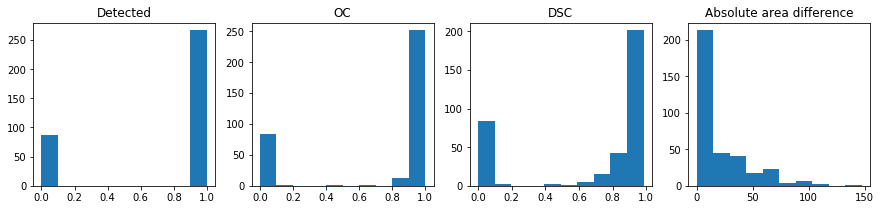

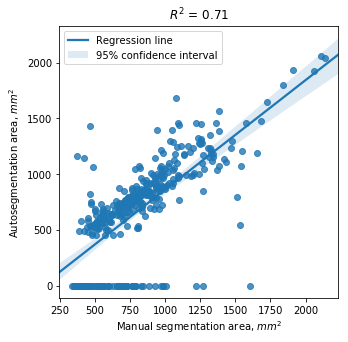

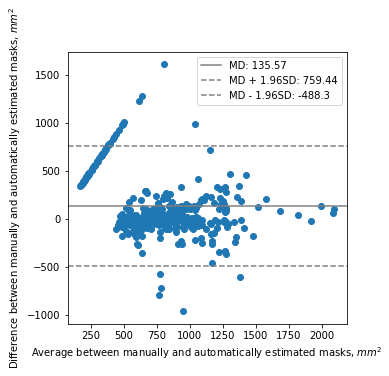

Patient

Mean TPR, OC, DSC:  1.0 0.8870930926135939 0.7970081368229689
Median TPR, OC, DSC:  1.0 0.8959162411738915 0.8140435394748755
IQR TPR, OC, DSC:  0.0 0.07199857999013948 0.10327614561731557
CP 90% CI TPR:  (0.8826538438450513, 1.0)
MSE volume, mm3:  302009.7648642101
Mean, median, IQR volume difference, mm3:  421.66276242772506 342.33173039520005 262.30434224085
Mean, median, IQR volume difference, rel:  0.17655532621362624 0.14152475438375522 0.08321773100660672
Volume difference ICC:  0.5621682584744905
R Spearman for volumes:  0.4730434782608695
R2 for volumes:  0.5297520874673365


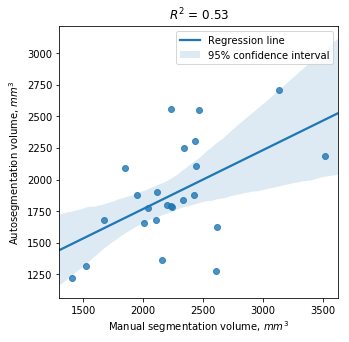

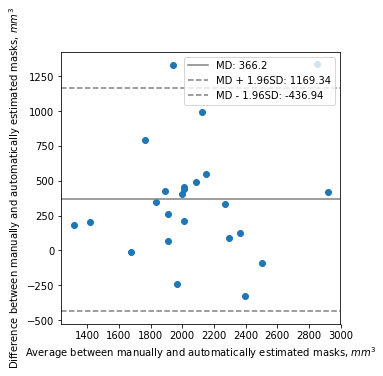

In [72]:
df_outcomes_test_unet_aug = get_outcomes(sub_names_test, ds_dir, results_dir_aug)

In [73]:
ds_dir = '../data/'
results_dir_simple = '../res/maps/T1w/plaq-u-net_simple/'
results_dir_aug = '../res/maps/T1w/plaq-u-net_aug/'

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Slice

Mean TPR, OC, DSC:  0.8810198300283286 0.8735649802509556 0.6628093481772142
Median TPR, OC, DSC:  1.0 1.0 0.7759131293188549
IQR TPR, OC, DSC:  0.0 0.0210280373831776 0.3055199425373033
CP 90% CI TPR:  (0.8488417781993098, 0.9083132276976742)
MSE area, mm2:  217637.85552407932
Mean, median, IQR area difference, mm2:  33.57935310616573 26.3544009183 30.945759963300002
Mean, median area difference, IQR, relative:  0.4289609847376904 0.35772357723577236 0.3604951925649762
Mean area GT, pred:  833.0651558073654 468.1728045325779
Median area GT, pred:  799.0 488.0
Area difference ICC:  0.4331938461853994
R Spearman for areas:  0.5617071914992969
R2 for areas:  0.5111340028888864


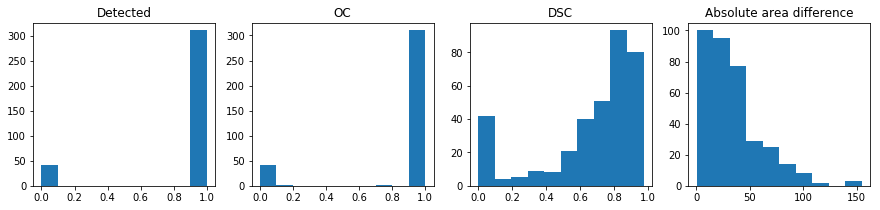

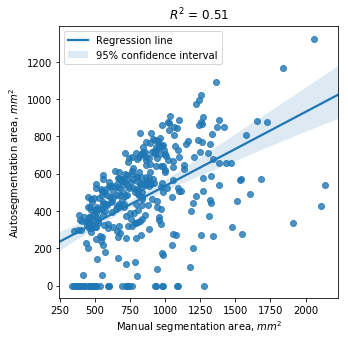

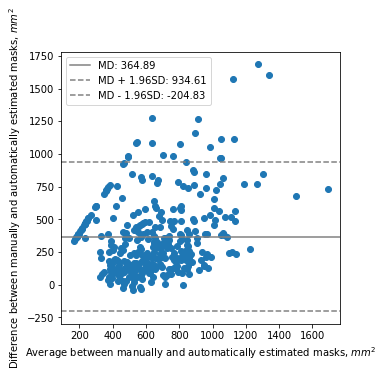

Patient

Mean TPR, OC, DSC:  1.0 0.9825125522225692 0.702918965405336
Median TPR, OC, DSC:  1.0 0.9927299933252081 0.7156042489432819
IQR TPR, OC, DSC:  0.0 0.011740968347268566 0.16757694063608275
CP 90% CI TPR:  (0.8826538438450513, 1.0)
MSE volume, mm3:  1147861.9710407252
Mean, median, IQR volume difference, mm3:  985.6653075155253 885.0303695142002 431.49592304910004
Mean, median, IQR volume difference, rel:  0.43001475681852863 0.4374717849562304 0.18580046182882975
Volume difference ICC:  0.1914794950352854
R Spearman for volumes:  0.40695652173913033
R2 for volumes:  0.44581797950482893


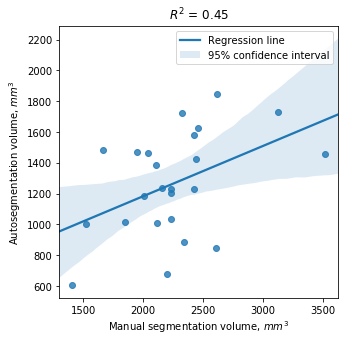

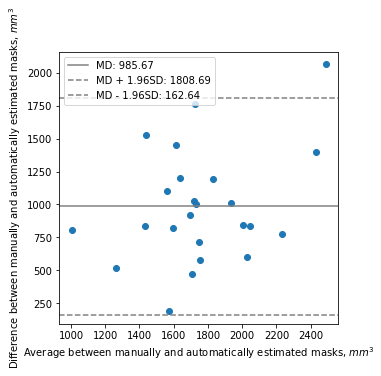

In [74]:
df_outcomes_test_plaqunet_simple = get_outcomes(sub_names_test, ds_dir, results_dir_simple)

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Slice

Mean TPR, OC, DSC:  0.8555240793201133 0.8364612843628397 0.7571786545732941
Median TPR, OC, DSC:  1.0 0.9838056680161943 0.901686121919585
IQR TPR, OC, DSC:  0.0 0.04010314559587025 0.1687665328123118
CP 90% CI TPR:  (0.8211032155685053, 0.885407878689607)
MSE area, mm2:  88485.80736543909
Mean, median, IQR area difference, mm2:  18.652623737262324 9.917335537200001 23.783239853100003
Mean, median area difference, IQR, relative:  0.2686890052493755 0.14678899082568808 0.23996693684691017
Mean area GT, pred:  833.0651558073654 659.5127478753541
Median area GT, pred:  799.0 668.0
Area difference ICC:  0.7867770198520355
R Spearman for areas:  0.7889651022745222
R2 for areas:  0.7372562778932328


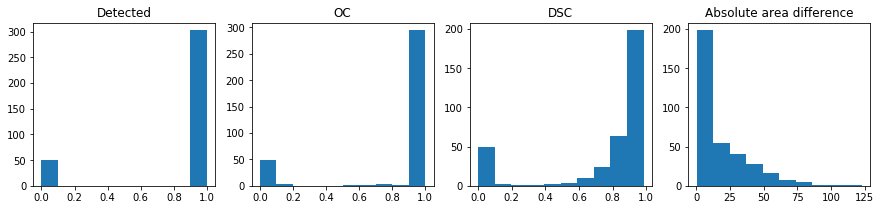

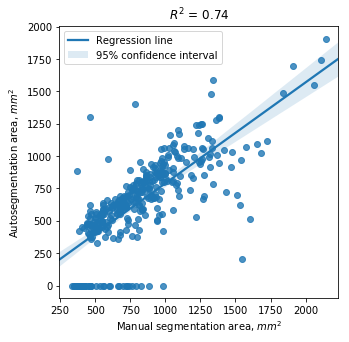

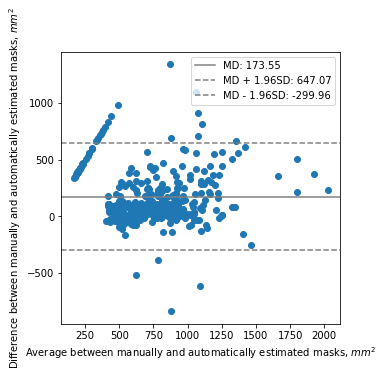

Patient

Mean TPR, OC, DSC:  1.0 0.9261309888955295 0.8164927567527283
Median TPR, OC, DSC:  1.0 0.9524152555542755 0.8284117877060544
IQR TPR, OC, DSC:  0.0 0.07610863501002141 0.10619457375360253
CP 90% CI TPR:  (0.8826538438450513, 1.0)
MSE volume, mm3:  327654.0868871801
Mean, median, IQR volume difference, mm3:  471.8386645245001 417.2627100096 512.9466325074002
Mean, median, IQR volume difference, rel:  0.20127275896239302 0.19391421153418203 0.1933229705680865
Volume difference ICC:  0.5918794684779893
R Spearman for volumes:  0.5382608695652172
R2 for volumes:  0.6911778277350459


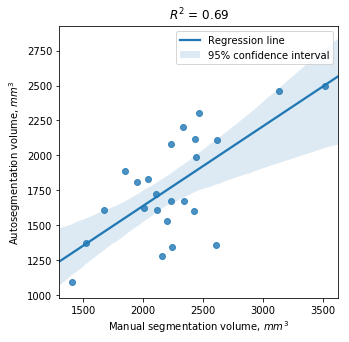

In [75]:
df_outcomes_test_plaqunet_aug = get_outcomes(sub_names_test, ds_dir, results_dir_aug)

In [76]:
ds_dir = '../data/'
results_dir_simple = '../res/maps/T1w/mask-rcnn_simple/'
results_dir_aug = '../res/maps/T1w/mask-rcnn_aug/'

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Slice

Mean TPR, OC, DSC:  0.1813031161473088 0.17846602485012497 0.1510557522305352
Median TPR, OC, DSC:  0.0 0.0 0.0
IQR TPR, OC, DSC:  0.0 0.0 0.0
CP 90% CI TPR:  (0.14824475727078293, 0.21840956646686793)
MSE area, mm2:  674509.1161473087
Mean, median, IQR area difference, mm2:  65.96157112309123 64.09537226820001 46.831862259000005
Mean, median area difference, IQR, relative:  0.8538072744906819 1.0 0.0
Mean area GT, pred:  833.0651558073654 117.94334277620396
Median area GT, pred:  799.0 0.0
Area difference ICC:  0.022683401731534783
R Spearman for areas:  0.0025084009100228956
R2 for areas:  0.046828404580523245


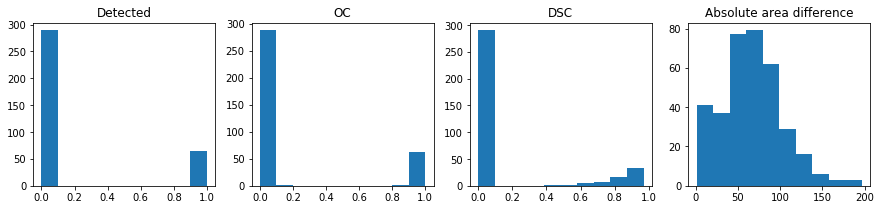

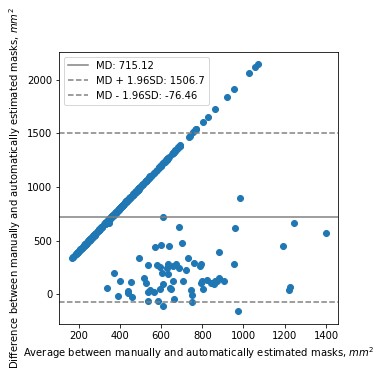

Patient

Mean TPR, OC, DSC:  0.5833333333333334 0.5519952329517611 0.19755712997364708
Median TPR, OC, DSC:  1.0 0.8503939893224346 0.09917036748873882
IQR TPR, OC, DSC:  1.0 0.9783139935515155 0.3451361578837745
CP 90% CI TPR:  (0.3967850681718578, 0.7536113708809807)
MSE volume, mm3:  4102821.2959634536
Mean, median, IQR volume difference, mm3:  1931.7224910028501 2042.3283303969001 773.0471224066505
Mean, median, IQR volume difference, rel:  0.8532969677751382 0.932333707008141 0.23506283632041847
Volume difference ICC:  -0.010012018701836286
R Spearman for volumes:  0.0687746764649315
R2 for volumes:  -0.05591349592799275


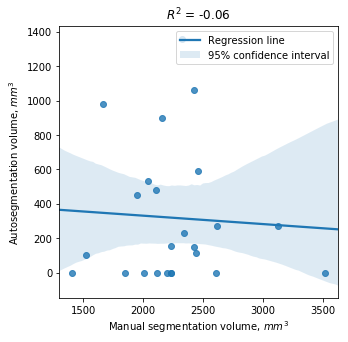

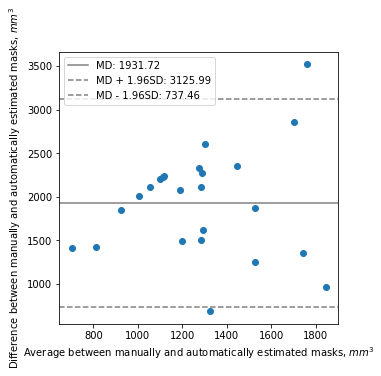

In [78]:
df_outcomes_test_maskrcnn_aug = get_outcomes(sub_names_test, ds_dir, results_dir_aug, mapstrategy=False)

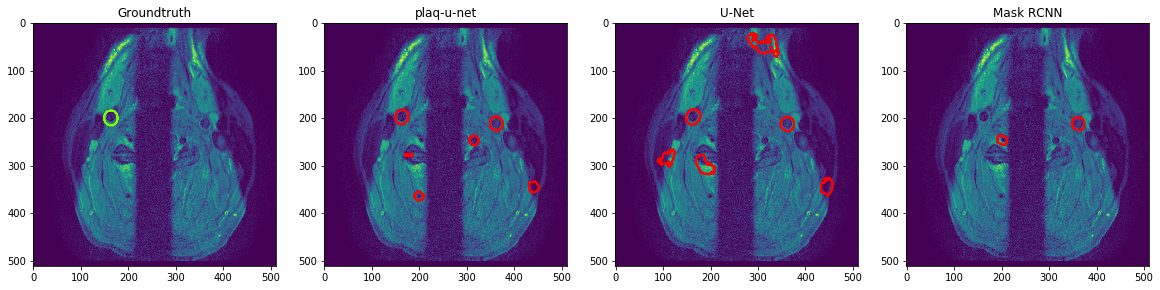

In [81]:
visualize_results('AMC006', 'sl0002')

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


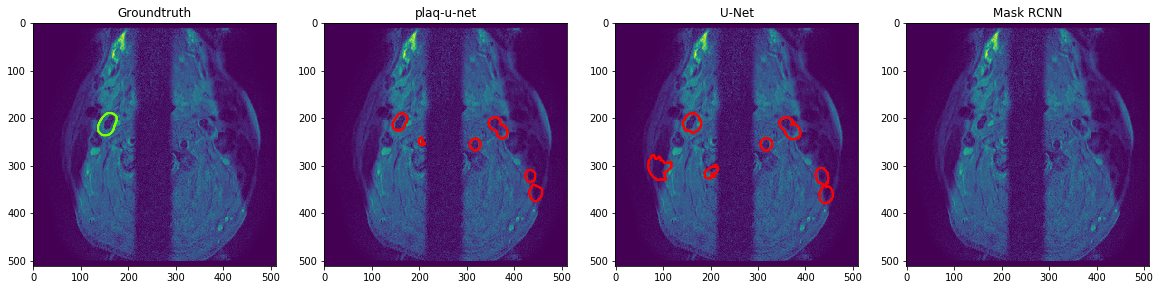

In [82]:
visualize_results('AMC006', 'sl0007')

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


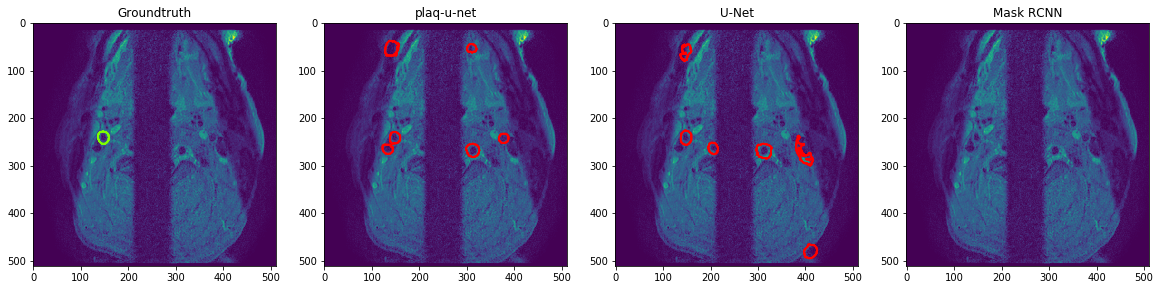

In [83]:
visualize_results('AMC006', 'sl0011')

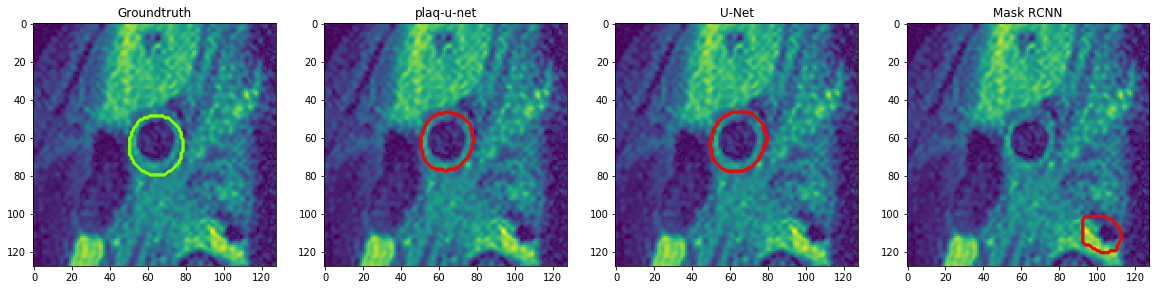

In [84]:
visualize_results('AMC006', 'sl0002', large=True)

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


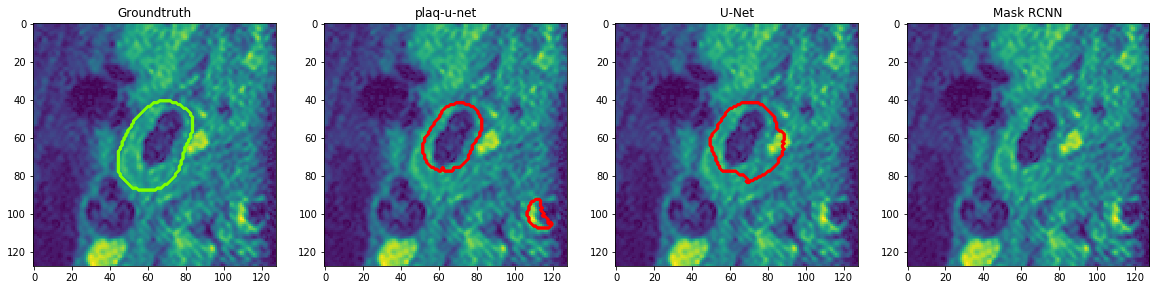

In [85]:
visualize_results('AMC006', 'sl0007', large=True)

In [86]:
visualize_results('AMC006', 'sl0011', large=True)

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


## EMC

In [87]:
sub_names_emc = ['EMC003', 'EMC004', 'EMC005', 'EMC007', 'EMC008', 'EMC009', 'EMC011', 'EMC015', 'EMC018', 'EMC020', 
                 'EMC024', 'EMC027', 'EMC029', 'EMC031', 'EMC032', 'EMC034', 'EMC035', 'EMC036', 'EMC038', 'EMC041', 
                 'EMC042', 'EMC043', 'EMC045', 'EMC046', 'EMC047', 'EMC048', 'EMC049', 'EMC050', 'EMC051', 'EMC052', 
                 'EMC054', 'EMC055', 'EMC056', 'EMC057']

In [88]:
ds_dir = '../data/'
results_dir_simple = '../res/maps/T1w/u-net_simple/'
results_dir_aug = '../res/maps/T1w/u-net_aug/'

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Slice

Mean TPR, OC, DSC:  0.6947162426614482 0.6731722568500312 0.6028880180389821
Median TPR, OC, DSC:  1.0 0.9696969696969697 0.837037037037037
IQR TPR, OC, DSC:  1.0 0.9973360859263043 0.9246311927223152
CP 90% CI TPR:  (0.6594443334045442, 0.7283035876297254)
MSE area, mm2:  26179.9843444227
Mean, median, IQR area difference, mm2:  35.5567086150685 25.390625 46.50998935500001
Mean, median area difference, IQR, relative:  0.4348013215967285 0.22647058823529412 0.8959919814413233
Mean area GT, pred:  317.42074363992174 219.18199608610567
Median area GT, pred:  287.0 230.0
Area difference ICC:  0.741531618865352
R Spearman for areas:  0.7233679307000747
R2 for areas:  0.7089202023106963


Patient

Mean TPR, OC, DSC:  0.9705882352941176 0.9056160791791174 0.7149351670196672
Median TPR, OC, DSC:  1.0 0.9421753280338656 0.7754793837658267
IQR TPR, OC, DSC:  0.0 0.08334223574387278 0.2310791245719207
CP 90% CI TPR:  (0.867926174868522, 0.9984925110991039)
MSE volume, mm3:  1093961.006942011
Mean, median, IQR volume difference, mm3:  909.869725134118 777.3598863900002 670.4317758150004
Mean, median, IQR volume difference, rel:  0.32863072029068296 0.29044373446929356 0.17466841113797046
Volume difference ICC:  0.624506636593278
R Spearman for volumes:  0.7402597402597402
R2 for volumes:  0.7589857136100827


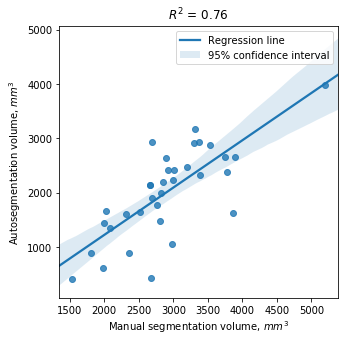

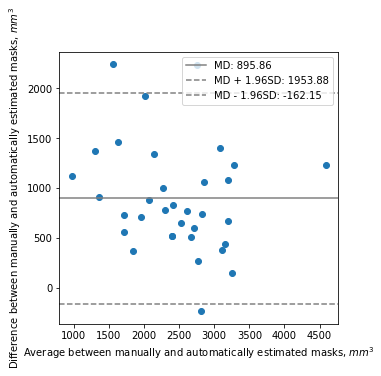

In [90]:
df_outcomes_emc_unet_aug = get_outcomes(sub_names_emc, ds_dir, results_dir_aug, cut=False)

In [91]:
ds_dir = '../data/'
results_dir_simple = '../res/maps/T1w/plaq-u-net_simple/'
results_dir_aug = '../res/maps/T1w/plaq-u-net_aug/'

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Slice

Mean TPR, OC, DSC:  0.5342465753424658 0.5297159371865922 0.32889753768955055
Median TPR, OC, DSC:  1.0 0.9902912621359223 0.3012987012987013
IQR TPR, OC, DSC:  1.0 1.0 0.6475118290096264
CP 90% CI TPR:  (0.496893438811138, 0.5713042284917957)
MSE area, mm2:  85700.457925636
Mean, median, IQR area difference, mm2:  73.82506224953035 64.00731654 59.072172975000015
Mean, median area difference, IQR, relative:  0.7440334485334504 0.8226299694189603 0.4918297787978375
Mean area GT, pred:  317.42074363992174 74.73972602739725
Median area GT, pred:  287.0 62.0
Area difference ICC:  0.029457244940566247
R Spearman for areas:  0.148452673086074
R2 for areas:  0.054427197197134736


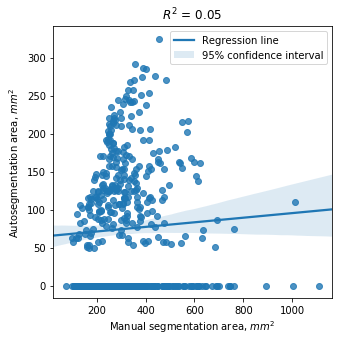

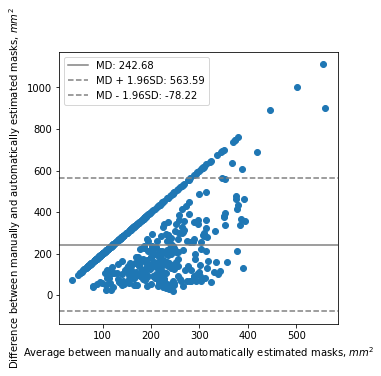

Patient

Mean TPR, OC, DSC:  0.8529411764705882 0.8447084952351931 0.35126102590806385
Median TPR, OC, DSC:  1.0 1.0 0.3652394408433485
IQR TPR, OC, DSC:  0.0 0.03131676190561028 0.4877165994620606
CP 90% CI TPR:  (0.7153513351429466, 0.9402144969957976)
MSE volume, mm3:  5780430.835901632
Mean, median, IQR volume difference, mm3:  2219.0945182064715 2239.6578796800004 1440.0925531199996
Mean, median, IQR volume difference, rel:  0.7481680644649134 0.7764293047133414 0.3532241431629489
Volume difference ICC:  -0.01484714294622531
R Spearman for volumes:  -0.08247905601478975
R2 for volumes:  -0.051925990553802794


In [92]:
df_outcomes_emc_plaqunet_simple = get_outcomes(sub_names_emc, ds_dir, results_dir_simple, cut=False)

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Slice

Mean TPR, OC, DSC:  0.8317025440313112 0.8229656315478037 0.6765513313503624
Median TPR, OC, DSC:  1.0 1.0 0.821917808219178
IQR TPR, OC, DSC:  0.0 0.021610084706196186 0.2630629277860572
CP 90% CI TPR:  (0.8020860731518331, 0.8584261977439656)
MSE area, mm2:  33084.86888454012
Mean, median, IQR area difference, mm2:  39.075187058317034 25.423466850000008 37.38745125000001
Mean, median area difference, IQR, relative:  0.3962099701543263 0.2840909090909091 0.3128896305848641
Mean area GT, pred:  317.42074363992174 190.43835616438355
Median area GT, pred:  287.0 190.0
Area difference ICC:  0.5276581676782937
R Spearman for areas:  0.6245088052653952
R2 for areas:  0.5332797099441869


Patient

Mean TPR, OC, DSC:  1.0 0.9716052400227692 0.7144616559318144
Median TPR, OC, DSC:  1.0 0.9950166753039288 0.7511119348840948
IQR TPR, OC, DSC:  0.0 0.03226873947713915 0.20314894912095038
CP 90% CI TPR:  (0.9156603566493746, 1.0)
MSE volume, mm3:  1844886.0744324508
Mean, median, IQR volume difference, mm3:  1152.1764209717649 943.3601699400001 836.8807087800002
Mean, median, IQR volume difference, rel:  0.3894062941401271 0.37159609705759056 0.2367047969124913
Volume difference ICC:  0.3223930438636245
R Spearman for volumes:  0.4826585179526356
R2 for volumes:  0.4528245423567455


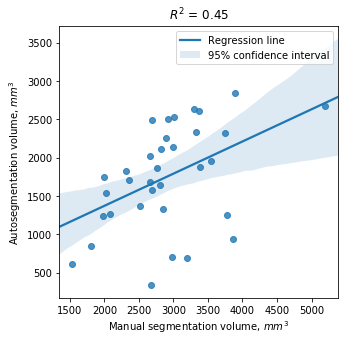

In [93]:
df_outcomes_emc_plaqunet_aug = get_outcomes(sub_names_emc, ds_dir, results_dir_aug, cut=False)

In [94]:
ds_dir = '../data/'
results_dir_simple = '../res/maps/T1w/mask-rcnn_simple/'
results_dir_aug = '../res/maps/T1w/mask-rcnn_aug/'

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Slice

Mean TPR, OC, DSC:  0.01761252446183953 0.017852150644993812 0.01187294725562506
Median TPR, OC, DSC:  0.0 0.0 0.0
IQR TPR, OC, DSC:  0.0 0.0 0.0
CP 90% CI TPR:  (0.009218229505547496, 0.030532713913909916)
MSE area, mm2:  121016.82778864971
Mean, median, IQR area difference, mm2:  95.64887950890413 85.84158807000001 50.54783409000001
Mean, median area difference, IQR, relative:  0.9902742234565018 1.0 0.0
Mean area GT, pred:  317.42074363992174 2.816046966731898
Median area GT, pred:  287.0 0.0
Area difference ICC:  -0.0014560356515182227
R Spearman for areas:  0.0062062811901862115
R2 for areas:  -0.013873545268276569


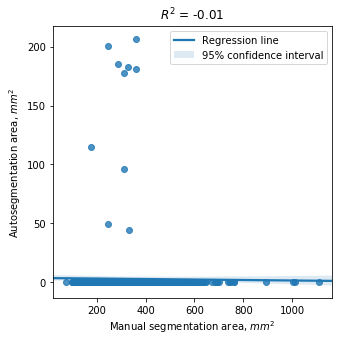

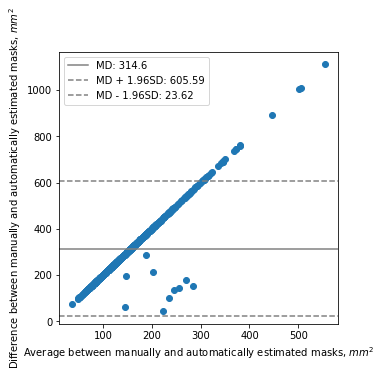

Patient

Mean TPR, OC, DSC:  0.23529411764705882 0.23889555822328934 0.016773641692857076
Median TPR, OC, DSC:  0.0 0.0 0.0
IQR TPR, OC, DSC:  0.0 0.09183673469387754 0.0018687707641196012
CP 90% CI TPR:  (0.12282976558880637, 0.3846567466725869)
MSE volume, mm3:  8767210.345316773
Mean, median, IQR volume difference, mm3:  2875.092789944118 2823.201218790001 743.2625308500001
Mean, median, IQR volume difference, rel:  0.9909851769434125 1.0 0.00770925110132159
Volume difference ICC:  0.0020688940371404634
R Spearman for volumes:  0.010823914680525727
R2 for volumes:  0.11513142747043804


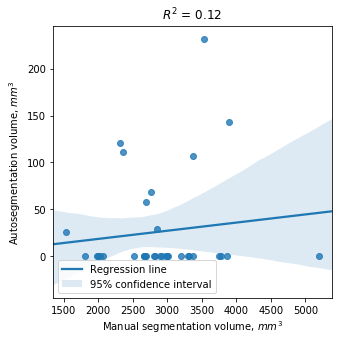

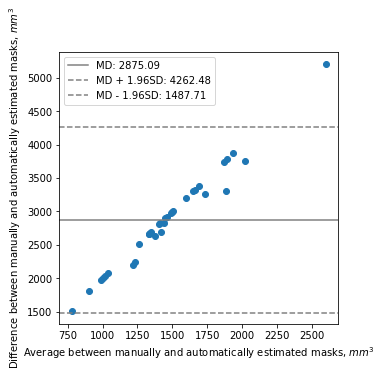

In [96]:
df_outcomes_emc_maskrcnn_aug = get_outcomes(sub_names_emc, ds_dir, results_dir_aug, cut=False, mapstrategy=False)

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


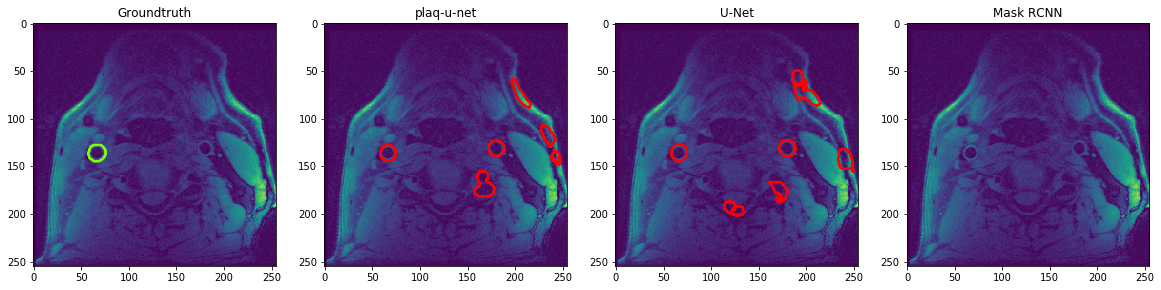

In [97]:
visualize_results('EMC004', 'sl0001', cut=False)

In [98]:
visualize_results('EMC004', 'sl0008', cut=False)

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


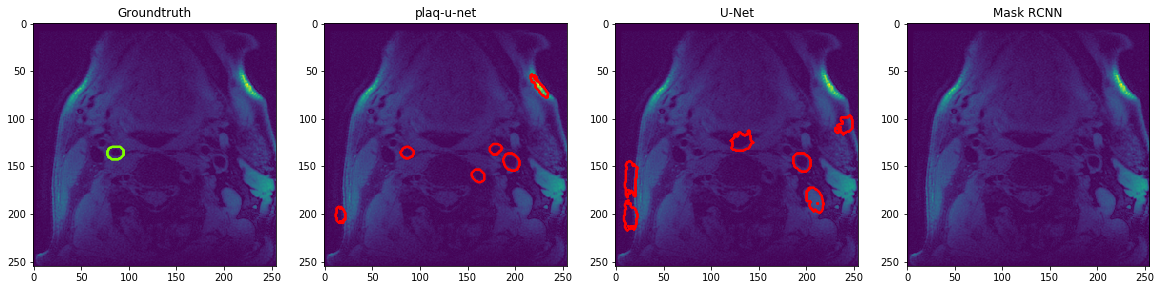

In [99]:
visualize_results('EMC004', 'sl0013', cut=False)

In [100]:
visualize_results('EMC004', 'sl0001', cut=False, large=True)

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


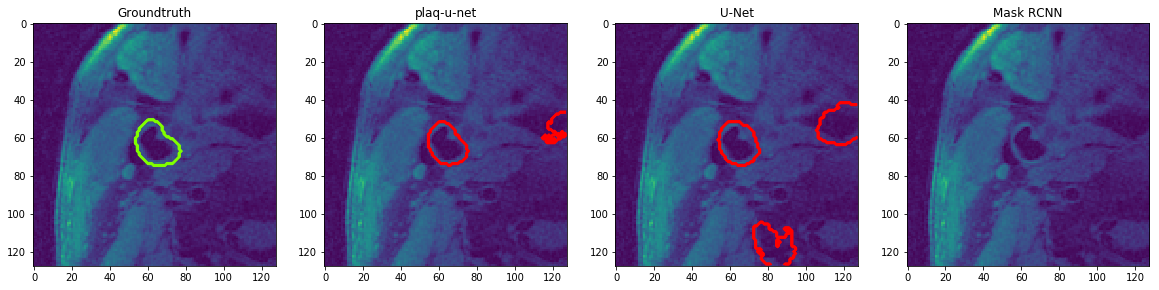

In [101]:
visualize_results('EMC004', 'sl0008', cut=False, large=True)

In [102]:
visualize_results('EMC004', 'sl0013', cut=False, large=True)

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


## Other modalities

### T2w

In [103]:
sub_names_test = ['AMC012', 'AMC006', 'MUMC094', 'MUMC027', 'MUMC079', 'MUMC052', 'MUMC127', 'MUMC071', 'MUMC038',
                  'MUMC093', 'MUMC107', 'MUMC022', 'MUMC114', 'MUMC115', 'MUMC069', 'MUMC130', 'MUMC036', 'MUMC007', 
                  'MUMC059', 'MUMC080', 'UMCU036', 'UMCU025', 'UMCU008', 'UMCU034']

In [104]:
ds_dir = '../data/'
results_dir_simple = '../res/maps/T2w/u-net_simple/'
results_dir_aug = '../res/maps/T2w/u-net_aug/'

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Slice

Mean TPR, OC, DSC:  0.5892351274787535 0.5691726350124107 0.5232588075236977
Median TPR, OC, DSC:  1.0 0.9371833839918946 0.7959493670886076
IQR TPR, OC, DSC:  1.0 0.981574539363484 0.9288956127080181
CP 90% CI TPR:  (0.5443067887237696, 0.6330421054345894)
MSE area, mm2:  283238.5552407932
Mean, median, IQR area difference, mm2:  34.643039629395474 23.966894214900005 48.48475151520002
Mean, median area difference, IQR, relative:  0.5087303066196792 0.2965931863727455 0.9146067415730337
Mean area GT, pred:  833.0651558073654 577.2634560906515
Median area GT, pred:  799.0 662.0
Area difference ICC:  0.5239276703039162
R Spearman for areas:  0.5291631214384467
R2 for areas:  0.4639074945182579


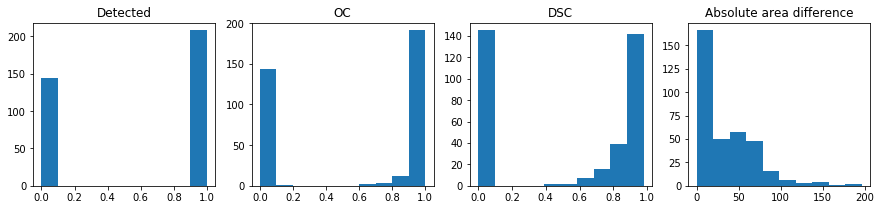

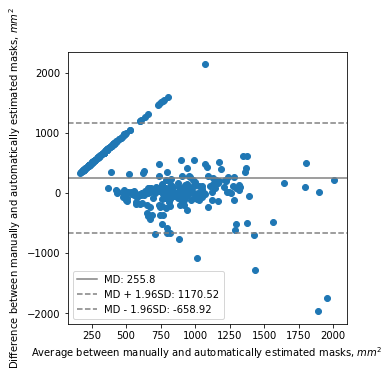

Patient

Mean TPR, OC, DSC:  0.9583333333333334 0.8339498307763143 0.6624615052987612
Median TPR, OC, DSC:  1.0 0.8577061089231854 0.6904421499910581
IQR TPR, OC, DSC:  0.0 0.11484470086282628 0.24290850658132113
CP 90% CI TPR:  (0.8171075302443536, 0.9978650616302984)
MSE volume, mm3:  834295.3471239792
Mean, median, IQR volume difference, mm3:  692.5605983478002 594.7646506893001 1081.4027958688503
Mean, median, IQR volume difference, rel:  0.2981296825234842 0.27374476143990406 0.46427592434268966
Volume difference ICC:  0.2895644567122781
R Spearman for volumes:  0.19826086956521738
R2 for volumes:  0.3222328223171503


In [106]:
df_outcomes_T2w_unet_aug = get_outcomes(sub_names_test, ds_dir, results_dir_aug)

In [107]:
ds_dir = '../data/'
results_dir_simple = '../res/maps/T2w/plaq-u-net_simple/'
results_dir_aug = '../res/maps/T2w/plaq-u-net_aug/'

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Slice

Mean TPR, OC, DSC:  0.7223796033994334 0.7137045535244169 0.6221226349669431
Median TPR, OC, DSC:  1.0 0.9842105263157894 0.8404575556893438
IQR TPR, OC, DSC:  1.0 0.9792284866468842 0.9026839826839828
CP 90% CI TPR:  (0.680452032057628, 0.7615019090619991)
MSE area, mm2:  210195.03116147307
Mean, median, IQR area difference, mm2:  30.161977254938247 19.742843893500005 34.618847199300006
Mean, median area difference, IQR, relative:  0.4143309150461078 0.25374105400130126 0.7947120312389774
Mean area GT, pred:  833.0651558073654 528.2606232294618
Median area GT, pred:  799.0 587.0
Area difference ICC:  0.5348933794647095
R Spearman for areas:  0.5975603865174182
R2 for areas:  0.5106379787682787


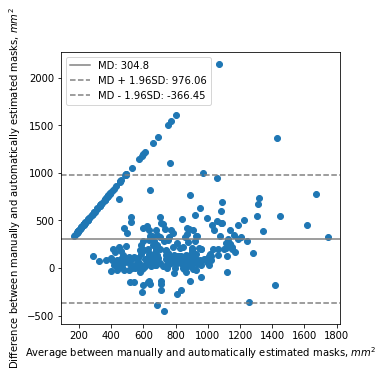

Patient

Mean TPR, OC, DSC:  1.0 0.9348337021865841 0.7139444599575984
Median TPR, OC, DSC:  1.0 0.9427193228597619 0.7362085383513113
IQR TPR, OC, DSC:  0.0 0.06422747957873531 0.25946972503103394
CP 90% CI TPR:  (0.8826538438450513, 1.0)
MSE volume, mm3:  949922.9520244263
Mean, median, IQR volume difference, mm3:  823.3531130097002 749.0343146013001 614.18609944965
Mean, median, IQR volume difference, rel:  0.3561853421826931 0.3601379390025624 0.3148547517253353
Volume difference ICC:  0.2588213358742326
R Spearman for volumes:  0.22
R2 for volumes:  0.3698103345693889


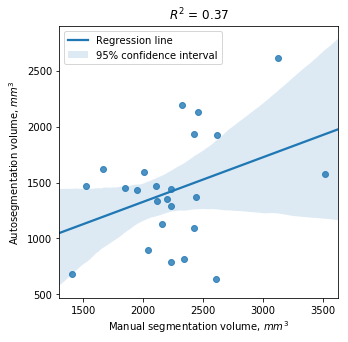

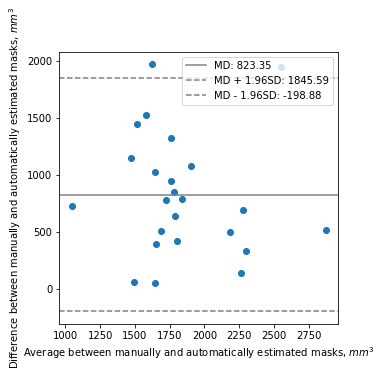

In [109]:
df_outcomes_T2w_plaqunet_aug = get_outcomes(sub_names_test, ds_dir, results_dir_aug)

In [110]:
ds_dir = '../data/'
results_dir_simple = '../res/maps/T2w/mask-rcnn_simple/'
results_dir_aug = '../res/maps/T2w/mask-rcnn_aug/'

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Slice

Mean TPR, OC, DSC:  0.21813031161473087 0.21523517590738203 0.1731637525628795
Median TPR, OC, DSC:  0.0 0.0 0.0
IQR TPR, OC, DSC:  0.0 0.0 0.0
CP 90% CI TPR:  (0.18242199193430075, 0.25740714652621877)
MSE area, mm2:  672554.3172804533
Mean, median, IQR area difference, mm2:  65.37991226617224 63.8198907255 48.39292433430001
Mean, median area difference, IQR, relative:  0.8397514768149505 1.0 0.0
Mean area GT, pred:  833.0651558073654 125.3314447592068
Median area GT, pred:  799.0 0.0
Area difference ICC:  -0.008728660722632299
R Spearman for areas:  -0.0353251095982278
R2 for areas:  -0.01769614089867152


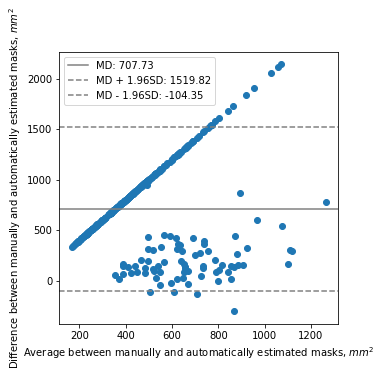

Patient

Mean TPR, OC, DSC:  0.6666666666666666 0.6320201441737466 0.22154191632047057
Median TPR, OC, DSC:  1.0 0.9446968190854871 0.1380094697824778
IQR TPR, OC, DSC:  1.0 0.9853540168303083 0.3968376202683253
CP 90% CI TPR:  (0.4785771051929929, 0.8220393747159949)
MSE volume, mm3:  4014258.7386322063
Mean, median, IQR volume difference, mm3:  1911.7653836872505 1973.0906359983 824.0571213966
Mean, median, IQR volume difference, rel:  0.8423089138050345 0.9249379836438771 0.31512703520407015
Volume difference ICC:  -0.015116919738714355
R Spearman for volumes:  -0.0783510206088123
R2 for volumes:  -0.08852970398938208


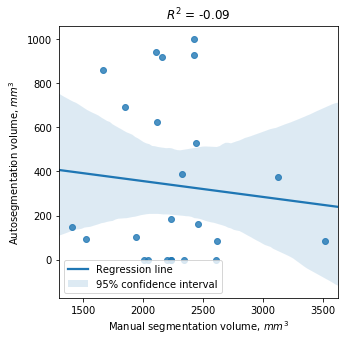

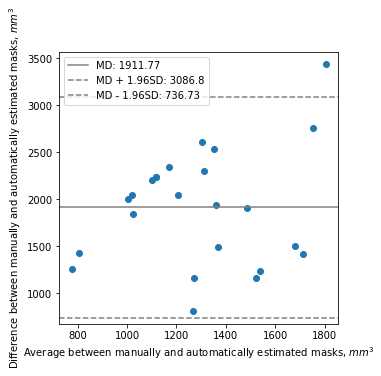

In [112]:
df_outcomes_T2w_maskrcnn_aug = get_outcomes(sub_names_test, ds_dir, results_dir_aug, mapstrategy=False)

### T1w CE

In [113]:
ds_dir = '../data/'
results_dir_simple = '../res/maps/T1wCE/u-net_simple/'
results_dir_aug = '../res/maps/T1wCE/u-net_aug/'

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Slice

Mean TPR, OC, DSC:  0.6572237960339944 0.6346903582397824 0.5777607184654987
Median TPR, OC, DSC:  1.0 0.9419354838709677 0.8672798948751642
IQR TPR, OC, DSC:  1.0 0.9808673469387755 0.9263531499556344
CP 90% CI TPR:  (0.6133759076327068, 0.6990931319051781)
MSE area, mm2:  229855.28895184136
Mean, median, IQR area difference, mm2:  31.10027935552267 16.6207197429 44.62800991740001
Mean, median area difference, IQR, relative:  0.4647906259102864 0.1966824644549763 0.9115826702033598
Mean area GT, pred:  833.0651558073654 679.5269121813031
Median area GT, pred:  799.0 782.0
Area difference ICC:  0.5687434481749224
R Spearman for areas:  0.5196379978536405
R2 for areas:  0.4650138702118374


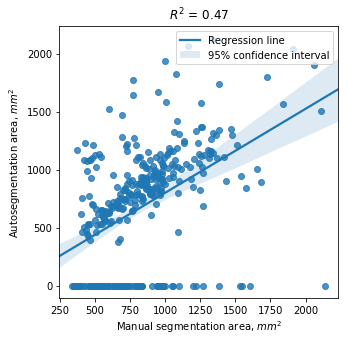

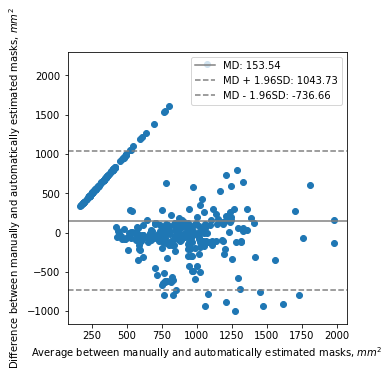

Patient

Mean TPR, OC, DSC:  0.9583333333333334 0.8203447411351692 0.6985988400144683
Median TPR, OC, DSC:  1.0 0.8852394067331039 0.7394758867720576
IQR TPR, OC, DSC:  0.0 0.15989851526944343 0.27408505324590626
CP 90% CI TPR:  (0.8171075302443536, 0.9978650616302984)
MSE volume, mm3:  608509.2866644153
Mean, median, IQR volume difference, mm3:  562.4338307474251 420.01752543660007 375.9404786046001
Mean, median, IQR volume difference, rel:  0.2407687312089467 0.1925197844415319 0.17874816001405727
Volume difference ICC:  0.3228319905438687
R Spearman for volumes:  0.3817391304347826
R2 for volumes:  0.25370020503803936


In [115]:
df_outcomes_T1wCE_unet_aug = get_outcomes(sub_names_test, ds_dir, results_dir_aug)

In [116]:
ds_dir = '../data/'
results_dir_simple = '../res/maps/T1wCE/plaq-u-net_simple/'
results_dir_aug = '../res/maps/T1wCE/plaq-u-net_aug/'

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Slice

Mean TPR, OC, DSC:  0.7620396600566572 0.7461354543831455 0.6500304294982537
Median TPR, OC, DSC:  1.0 0.9787735849056604 0.8510266491917868
IQR TPR, OC, DSC:  0.0 0.22234791976562684 0.5190258489648544
CP 90% CI TPR:  (0.721771900946806, 0.798994567724988)
MSE area, mm2:  178383.56373937678
Mean, median, IQR area difference, mm2:  27.93731422078301 18.549090541800002 37.557316988100006
Mean, median area difference, IQR, relative:  0.3942838811384186 0.23516483516483516 0.518081550802139
Mean area GT, pred:  833.0651558073654 587.3597733711048
Median area GT, pred:  799.0 633.0
Area difference ICC:  0.5739978665728266
R Spearman for areas:  0.5590901319660353
R2 for areas:  0.5076576705162131


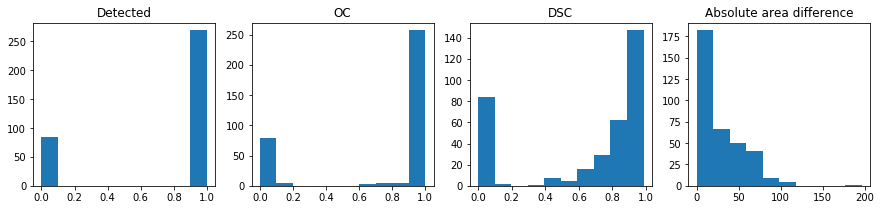

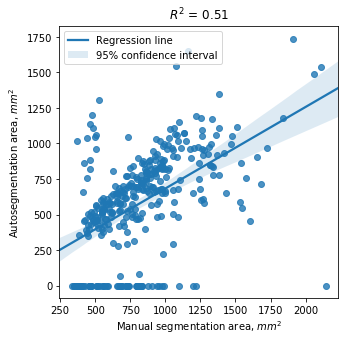

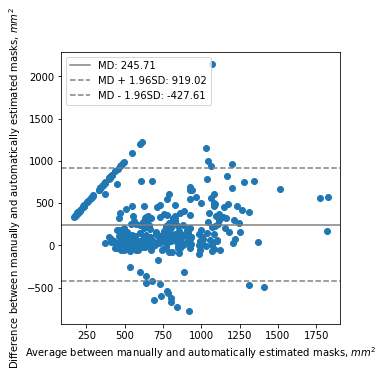

Patient

Mean TPR, OC, DSC:  1.0 0.9005360229264165 0.7336589212150595
Median TPR, OC, DSC:  1.0 0.9442740827306133 0.7252618223788188
IQR TPR, OC, DSC:  0.0 0.05987499670915164 0.22891496320630367
CP 90% CI TPR:  (0.8826538438450513, 1.0)
MSE volume, mm3:  675401.601596469
Mean, median, IQR volume difference, mm3:  670.50677040165 637.2806354460001 785.8111005517501
Mean, median, IQR volume difference, rel:  0.28924797018450027 0.32057252139916836 0.30369536735730673
Volume difference ICC:  0.343240459146289
R Spearman for volumes:  0.45739130434782604
R2 for volumes:  0.41865742068828726


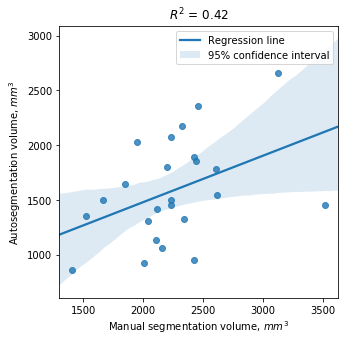

In [118]:
df_outcomes_T1wCE_plaqunet_aug = get_outcomes(sub_names_test, ds_dir, results_dir_aug)

In [119]:
ds_dir = '../data/'
results_dir_simple = '../res/maps/T1wCE/mask-rcnn_simple/'
results_dir_aug = '../res/maps/T1wCE/mask-rcnn_aug/'

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Slice

Mean TPR, OC, DSC:  0.31444759206798867 0.3072029156724854 0.2634733256785968
Median TPR, OC, DSC:  0.0 0.0 0.0
IQR TPR, OC, DSC:  1.0 0.9558998808104887 0.742998352553542
CP 90% CI TPR:  (0.2736577445685367, 0.35757459145457565)
MSE area, mm2:  601806.6232294617
Mean, median, IQR area difference, mm2:  58.74650401418925 54.2698639119 56.473716253500015
Mean, median area difference, IQR, relative:  0.7468214017585751 1.0 0.6155555555555556
Mean area GT, pred:  833.0651558073654 203.05949008498584
Median area GT, pred:  799.0 0.0
Area difference ICC:  -0.00846988859261265
R Spearman for areas:  0.004828832499369079
R2 for areas:  -0.012458233979635146


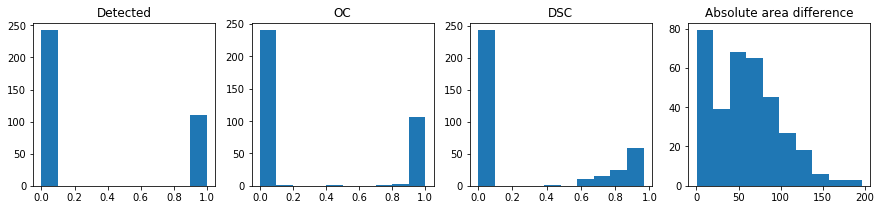

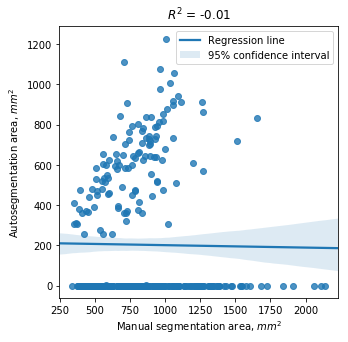

Patient

Mean TPR, OC, DSC:  0.7916666666666666 0.733461176074003 0.33035813197802527
Median TPR, OC, DSC:  1.0 0.9279798697019149 0.304654561758814
IQR TPR, OC, DSC:  0.0 0.17113807762071853 0.44932301776892775
CP 90% CI TPR:  (0.6108606526401017, 0.9141145875681924)
MSE volume, mm3:  3385584.6410928653
Mean, median, IQR volume difference, mm3:  1701.8025345593996 1669.4181487620003 686.27043645615
Mean, median, IQR volume difference, rel:  0.7397233567414293 0.8141564323159194 0.3280565413077947
Volume difference ICC:  -0.057981208685857634
R Spearman for volumes:  -0.0687554655523964
R2 for volumes:  -0.2219614858988967


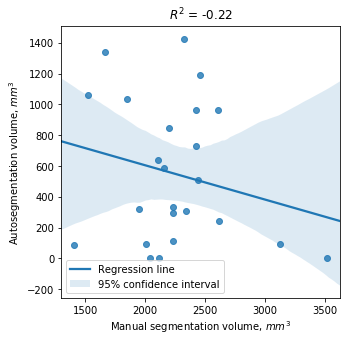

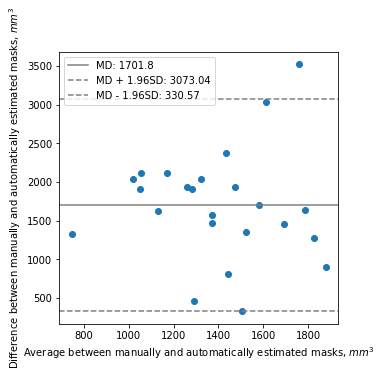

In [121]:
df_outcomes_T1wCE_maskrcnn_aug = get_outcomes(sub_names_test, ds_dir, results_dir_aug, mapstrategy=False)

## Comparison

In [132]:
from scipy.stats import mannwhitneyu

def compare_scores(df_1, df_2, score):
    
    list_1 = np.array([item for items in list(df_1[score]) for item in items])
    list_2 = np.array([item for items in list(df_2[score]) for item in items])
    
    U1, p = mannwhitneyu(list_1, list_2)
    
    return p

### A. plaq-u-net vs plaq-u-net with data augmentation

In [136]:
print ('plaq-u-net non- vs augmented (detection/segmentation):')

print ('test set:')

print ('Slice TPR: ', compare_scores(df_outcomes_test_plaqunet_simple, df_outcomes_test_plaqunet_aug, 'detect_slice'))
print ('Slice OC: ', compare_scores(df_outcomes_test_plaqunet_simple, df_outcomes_test_plaqunet_aug, 'overlap_slice'))
print ('Slice DSC: ', compare_scores(df_outcomes_test_plaqunet_simple, df_outcomes_test_plaqunet_aug, 'dice_slice'))

print ('Volume TPR: ', 
       mannwhitneyu(list(df_outcomes_test_plaqunet_simple['detect_patient']), 
                    list(df_outcomes_test_plaqunet_aug['detect_patient']))[1])
print ('Volume OC: ', 
       mannwhitneyu(list(df_outcomes_test_plaqunet_simple['overlap_patient']), 
                    list(df_outcomes_test_plaqunet_aug['overlap_patient']))[1])

print ('Volume DSC: ', 
       mannwhitneyu(list(df_outcomes_test_plaqunet_simple['dice_patient']), 
                    list(df_outcomes_test_plaqunet_aug['dice_patient']))[1])

print ('external test set:')

print ('Slice TPR: ', compare_scores(df_outcomes_emc_plaqunet_simple, df_outcomes_emc_plaqunet_aug, 'detect_slice'))
print ('Slice OC: ', compare_scores(df_outcomes_emc_plaqunet_simple, df_outcomes_emc_plaqunet_aug, 'overlap_slice'))
print ('Slice DSC: ', compare_scores(df_outcomes_emc_plaqunet_simple, df_outcomes_emc_plaqunet_aug, 'dice_slice'))

print ('Volume TPR: ', 
       mannwhitneyu(list(df_outcomes_emc_plaqunet_simple['detect_patient']), 
                    list(df_outcomes_emc_plaqunet_aug['detect_patient']))[1])
print ('Volume OC: ', 
       mannwhitneyu(list(df_outcomes_emc_plaqunet_simple['overlap_patient']), 
                    list(df_outcomes_emc_plaqunet_aug['overlap_patient']))[1])

print ('Volume DSC: ', 
       mannwhitneyu(list(df_outcomes_emc_plaqunet_simple['dice_patient']), 
                    list(df_outcomes_emc_plaqunet_aug['dice_patient']))[1])

plaq-u-net non- vs augmented (detection/segmentation):
test set:
Slice TPR:  0.3170557357999023
Slice OC:  2.5555790033640505e-13
Slice DSC:  2.594397163193229e-20
Volume TPR:  1.0
Volume OC:  4.938653552154245e-06
Volume DSC:  0.000748107596402603
external test set:
Slice TPR:  1.735312011461316e-24
Slice OC:  5.721757892180425e-15
Slice DSC:  1.0440548004281151e-60
Volume TPR:  0.021882720460877074
Volume OC:  0.09897121962920853
Volume DSC:  2.1812750850742088e-07


In [141]:
print ('plaq-u-net non- vs augmented (agreement):')

print ('test set:')

print ('Slice area difference: ', 
       compare_scores(df_outcomes_test_plaqunet_simple, df_outcomes_test_plaqunet_aug, 'area_difference_slice'))
print ('Volume difference: ', 
       mannwhitneyu(list(df_outcomes_test_plaqunet_simple['volume_difference_patient_abs']), 
                    list(df_outcomes_test_plaqunet_aug['volume_difference_patient_abs']))[1])

print ('external test set:')

print ('Slice area difference: ', 
       compare_scores(df_outcomes_emc_plaqunet_simple, df_outcomes_emc_plaqunet_aug, 'area_difference_slice'))
print ('Volume difference: ', 
       mannwhitneyu(list(df_outcomes_emc_plaqunet_simple['volume_difference_patient_abs']), 
                    list(df_outcomes_emc_plaqunet_aug['volume_difference_patient_abs']))[1])

plaq-u-net non- vs augmented (agreement):
test set:
Slice area difference:  2.14693510689804e-21
Volume difference:  6.607022058463276e-05
external test set:
Slice area difference:  2.929722098671581e-46
Volume difference:  6.946361876864552e-06


### plaq-u-net vs U-Net vs mask R-CNN